In [338]:
import torch
import numpy as np

seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

# get task vectors. all orthogonal
dim = 1000
n_task = 100
gaus = torch.randn(dim, dim)
u, s, v = torch.svd(gaus)

# power law distribution
alpha = 2
prob = 1/(np.arange(n_task) + 1)**(alpha)
prob /= np.sum(prob)

noise_scale = 0e-3


task_vectors = u[:n_task]

batch_size = 1024

# initial and target
x = torch.nn.Parameter(torch.zeros(dim,))

learning_rate = 3e-4
#optimizer = torch.optim.SGD([x], lr=learning_rate)
optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.0,0.0))
target = torch.sum(task_vectors, dim=0)


n_steps = 3000
log = 500
task_abilities = []
losses = []
losses_skill = []
n_uses = []


for i in range(n_steps):

    optimizer.zero_grad()

    # project and get progress
    task_ability = task_vectors @ x
    
    loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
    task_abilities.append(task_ability.detach().numpy())
    losses.append(loss)
    losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

    # mimic gradient
    id = np.random.choice(n_task, batch_size, p=prob)
    task_vectors_batch = task_vectors[id]
    task_ability_batch = task_ability[id]
    
    #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
    neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

    neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)
    
    # update 
    x.grad = - neg_grad + torch.randn(dim) * noise_scale
    optimizer.step()
    
    # compute #(used dimension)
    alignment = task_vectors * neg_grad[None, :] > 0
    n_used = torch.sum(alignment, dim=1)
    n_uses.append(n_used.detach().numpy())
    
    if i % log == 0:
        print(i)

task_abilities = np.array(task_abilities)
losses = np.array(losses)
n_uses = np.array(n_uses)
losses_skill = np.array(losses_skill)

results = {}
results['losses'] = losses
results['n_uses'] = n_uses
results['task_abilities'] = task_abilities

#np.savez(f"./results/effind_ntask_{alpha}_{n_task}", **results)

0
500
1000
1500
2000
2500


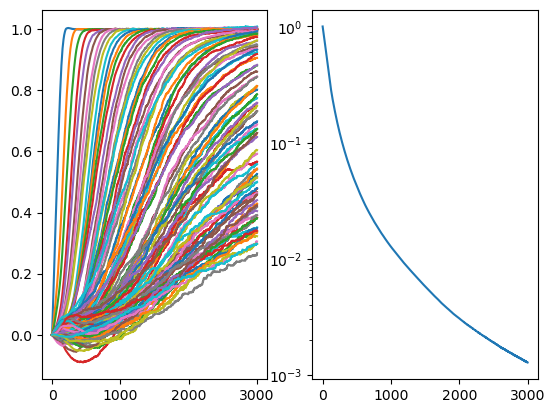

In [339]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(10,1))

plt.subplot(1,2,1)

for i in range(n_task):
    plt.plot(task_abilities[:,i])
    
#plt.xlim(1,300)
#plt.xscale('log')
    
plt.subplot(1,2,2)
plt.plot(losses)
plt.yscale('log')


In [344]:
import copy

l = np.ones(n_task,)

lr = learning_rate * np.sqrt(dim) * 2
n_steps2 = 3000

ls = []

for i in range(n_steps2):
    fg = prob * l
    fg_norm = fg/(np.sum(fg) + 0.006)
    l -= lr * fg_norm
    l = np.maximum(l, 0.)
    #l = np.exp(-lr*prob/(np.sum(fg)+0.01)) * l
    ls.append(copy.deepcopy(l))
    
ls = np.array(ls)

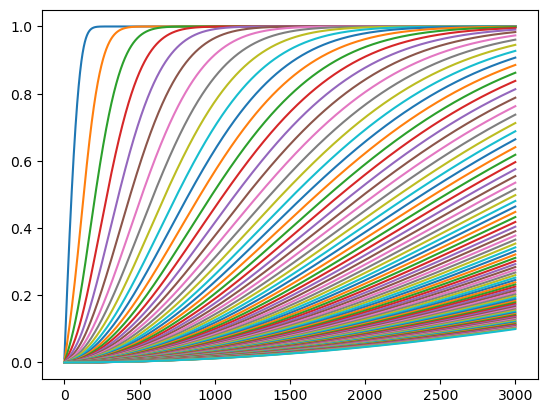

In [345]:
for i in range(n_task):
    plt.plot(1-ls[:,i])

In [1]:
import torch
import numpy as np
import copy

seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

results = {}

modes = ['orig', 'alpha', 'dim', 'ntask', 'lr', 'noise', 'betas', 'bs']

for mode in modes:

    # get task vectors. all orthogonal
    dim = 1000
    
    if mode == 'dim':
        dim = 100
        N0 = 0.003
    
    n_task = 10
    
    if mode == 'ntask':
        n_task = 100
        N0 = 0.003
    
    gaus = torch.randn(dim, dim)
    u, s, v = torch.svd(gaus)

    # power law distribution
    alpha = 2
    
    if mode == 'alpha':
        alpha = 4
        N0 = 0.003

    prob = 1/(np.arange(n_task) + 1)**(alpha)
    prob /= np.sum(prob)

    noise_scale = 0e-3
    if mode == 'noise':
        noise_scale = 1e-3
        N0 = 0.06

    task_vectors = u[:n_task]

    batch_size = 1024
    if mode == 'bs':
        batch_size = 16
        N0 = 0.05

    # initial and target
    x = torch.nn.Parameter(torch.zeros(dim,))

    learning_rate = 3e-4
    optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.0,0.0))
    target = torch.sum(task_vectors, dim=0)


    n_steps = 3000
    log = 500
    task_abilities = []
    losses = []
    losses_skill = []
    n_uses = []

    if mode == 'orig':
        N0 = 0.003


    if mode == 'lr':
        learning_rate = 1e-4
        optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.0,0.0))
        N0 = 0.001


    if mode == 'betas':
        optimizer = torch.optim.Adam([x], lr=learning_rate)
        N0 = 0.08
        
    if mode == 'ntask':
        N0 = 0.01


    print(mode)

    for i in range(n_steps):

        optimizer.zero_grad()

        # project and get progress
        task_ability = task_vectors @ x

        loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
        task_abilities.append(task_ability.detach().numpy())
        losses.append(loss)
        losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

        # mimic gradient
        id = np.random.choice(n_task, batch_size, p=prob)
        task_vectors_batch = task_vectors[id]
        task_ability_batch = task_ability[id]

        neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

        neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)

        # update 
        x.grad = - neg_grad + torch.randn(dim) * noise_scale
        optimizer.step()

        # compute #(used dimension)
        alignment = task_vectors * neg_grad[None, :] > 0
        n_used = torch.sum(alignment, dim=1)
        n_uses.append(n_used.detach().numpy())

        if i % log == 0:
            print(i)

    task_abilities = np.array(task_abilities)
    losses = np.array(losses)
    n_uses = np.array(n_uses)
    losses_skill = np.array(losses_skill)


    results[f'{mode}_experiment'] = task_abilities

    #np.savez(f"./results/effind_ntask_{alpha}_{n_task}", **results)

    l = np.ones(n_task,)

    lr = learning_rate * np.sqrt(dim) * 2
        
    n_steps2 = 3000

    ls = []

    for i in range(n_steps2):
        fg = prob * l
        fg_norm = fg/(np.sum(fg) + N0)
        l -= lr * fg_norm
        l = np.maximum(l, 0.)
        #l = np.exp(-lr*prob/(np.sum(fg)+0.01)) * l
        ls.append(copy.deepcopy(l))

    ls = np.array(ls)

    results[f'{mode}_theory'] = 1 - ls

orig
0
500
1000
1500
2000
2500
alpha
0
500
1000
1500
2000
2500
dim
0
500
1000
1500
2000
2500
ntask
0
500
1000
1500
2000
2500
lr
0
500
1000
1500
2000
2500
noise
0
500
1000
1500
2000
2500
betas
0
500
1000
1500
2000
2500
bs
0
500
1000
1500
2000
2500


/state/partition1/slurm_tmp/27791056.0.0/ipykernel_142753/3717172791.py:31: RuntimeWarning: overflow encountered in power
  plt.plot(np.maximum((1-experiment[:,i]), 0.)**(1/prob[i]), color=cmap(i/(n_task-1)))


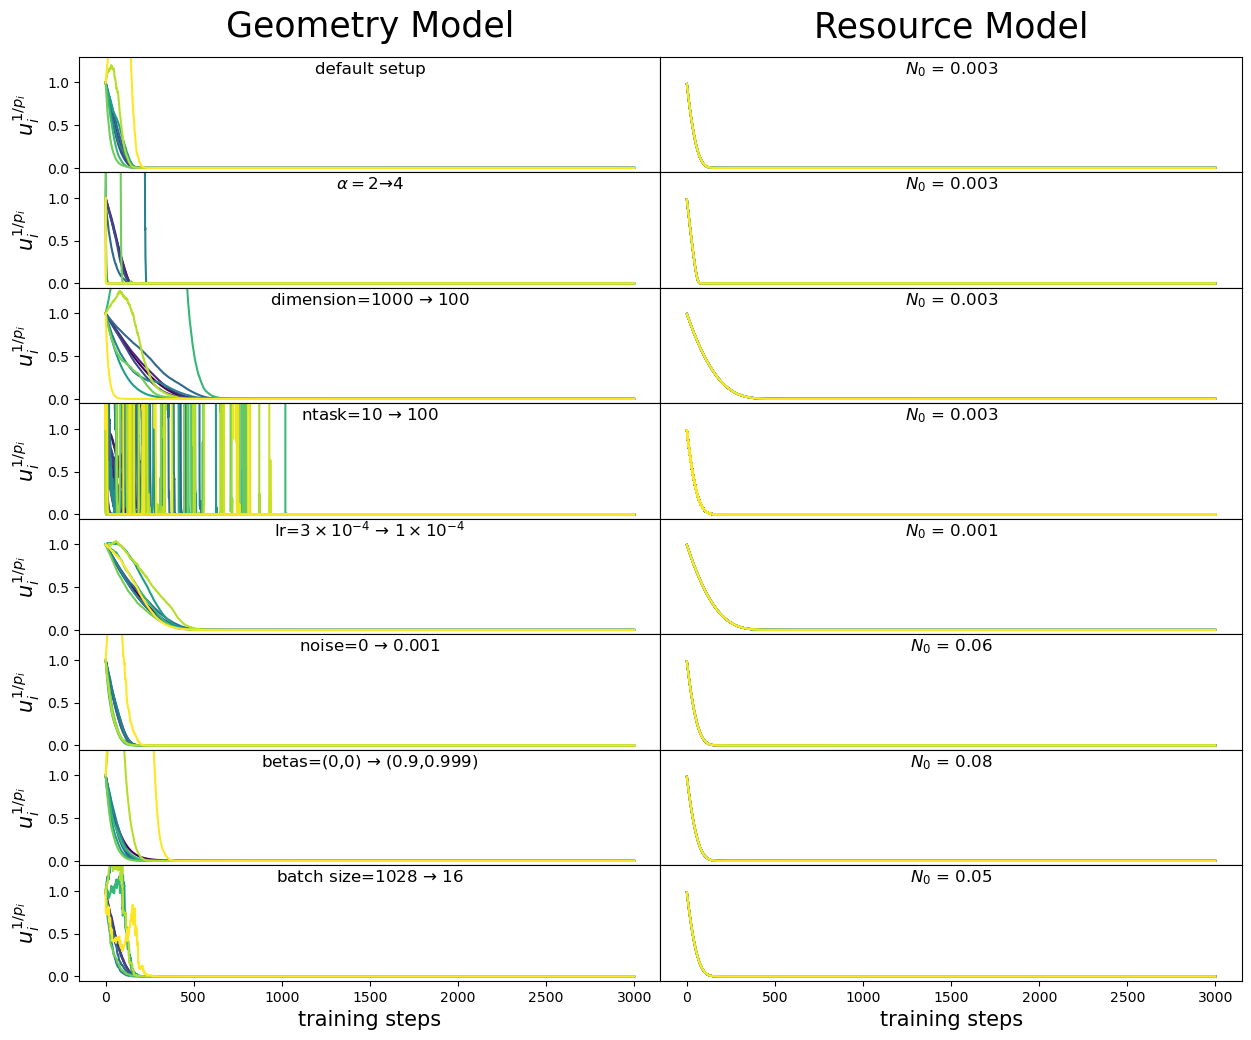

In [20]:
import matplotlib.pyplot as plt

ii = 0

plt.figure(figsize=(15,12))

cmap = plt.get_cmap('viridis') 

N0s = [0.003,0.003,0.003,0.003,0.001,0.06,0.08,0.05]

for mode in modes:

    theory = results[f'{mode}_theory']
    experiment = results[f'{mode}_experiment']

    plt.subplot(8,2,2*ii+1)

    if mode == 'ntask':
        n_task = 100
    else:
        n_task = 10
        
    if mode == 'alpha':
        alpha = 4
    else:
        alpha = 2
    prob = 1/(np.arange(n_task) + 1)**(alpha)
    prob /= np.sum(prob)
        
    for i in range(n_task):
        plt.plot(np.maximum((1-experiment[:,i]), 0.)**(1/prob[i]), color=cmap(i/(n_task-1)))
           
        
    x0 = 1500
    y0 = 1.1
    
    if ii == 0:
        plt.text(x0,y0,'default setup', fontsize = 12, horizontalalignment='center')
    if ii == 1:
        plt.text(x0,y0,r'$\alpha=2 \to 4$', fontsize = 12, horizontalalignment='center')
    if ii == 2:
        plt.text(x0,y0,r'dimension=1000 $\to$ 100', fontsize = 12, horizontalalignment='center')
    if ii == 3:
        plt.text(x0,y0,r'ntask=10 $\to$ 100', fontsize = 12, horizontalalignment='center')
    if ii == 4:
        plt.text(x0,y0,r'lr=$3\times 10^{-4}$ $\to$ $1\times 10^{-4}$', fontsize = 12, horizontalalignment='center')
    if ii == 5:
        plt.text(x0,y0,r'noise=0 $\to$ 0.001', fontsize = 12, horizontalalignment='center')
    if ii == 6:
        plt.text(x0,y0,r'betas=(0,0) $\to$ (0.9,0.999)', fontsize = 12, horizontalalignment='center')
    if ii == 7:
        plt.text(x0,y0,r'batch size=1028 $\to$ 16', fontsize = 12, horizontalalignment='center')
    

    plt.ylim(-0.05,1.3)
    
    plt.ylabel(r'$u_i^{1/p_i}$', fontsize=15, rotation=90)
    
    if ii == 7:
        plt.xlabel('training steps', fontsize=15)
        
    if ii == 0:
        plt.title('Geometry Model', fontsize=25, y=1.1)

    plt.subplot(8,2,2*ii+2)

    for i in range(n_task):
        plt.plot(np.maximum((1-theory[:,i]),0.)**(1/prob[i]), color=cmap(i/(n_task-1)))
        
    plt.text(x0, y0, r"$N_0$ = "+f"{N0s[ii]}", fontsize = 12, horizontalalignment='center')
        
    plt.yticks([])
    
    if ii == 0:
        plt.title('Resource Model', fontsize=25, y=1.1)
    
    plt.ylim(-0.05,1.3)
    
    if ii == 7:
        plt.xlabel('training steps', fontsize=15)
        
    ii += 1
    
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./plot/experiment_theory_compare_collapse.pdf', bbox_inches='tight')

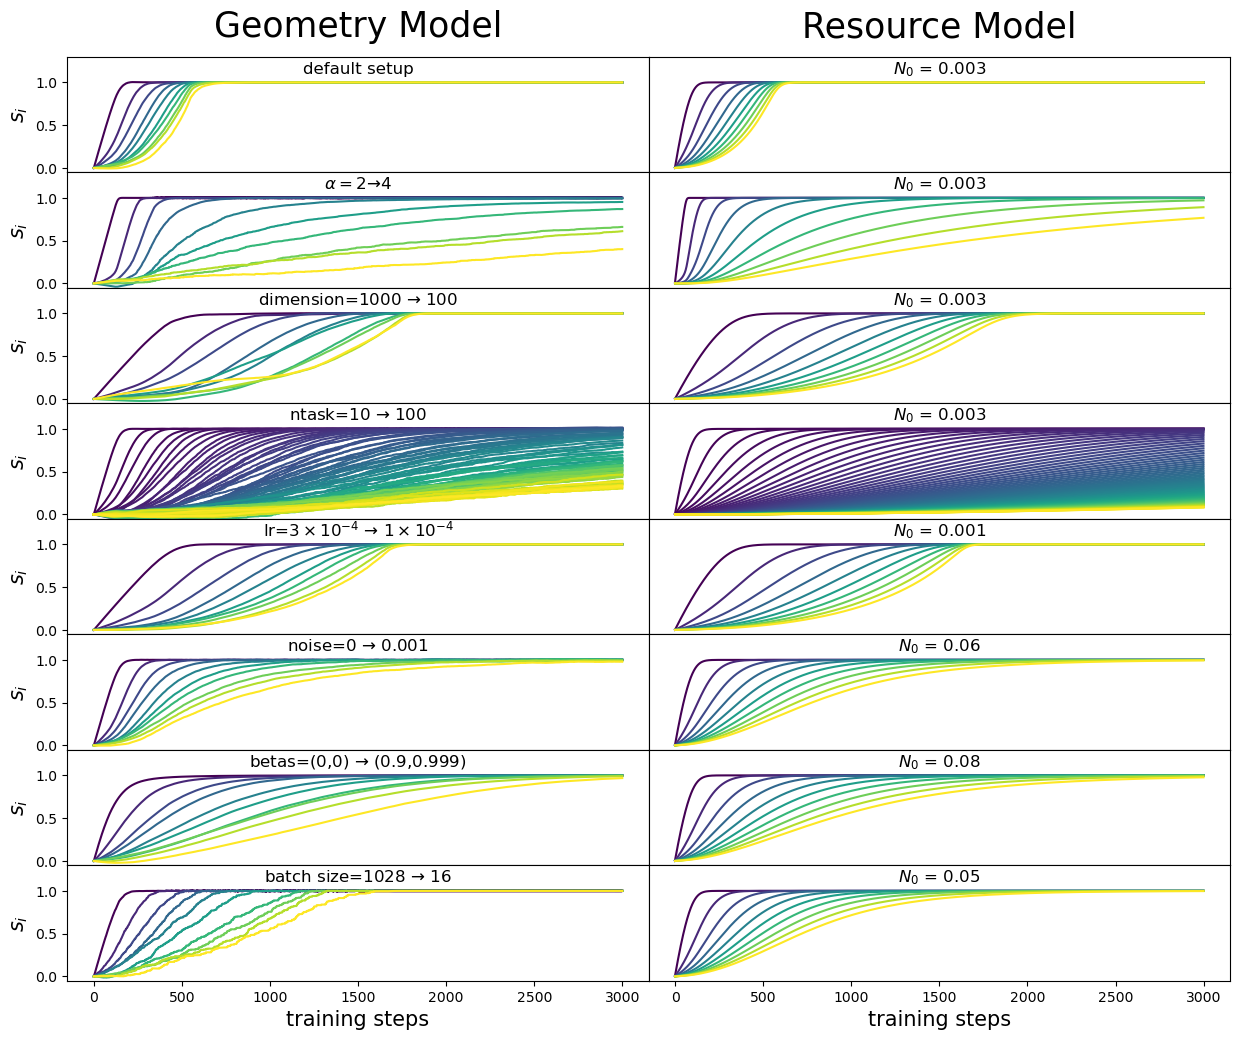

In [25]:
import matplotlib.pyplot as plt

ii = 0

plt.figure(figsize=(15,12))

cmap = plt.get_cmap('viridis') 

N0s = [0.003,0.003,0.003,0.003,0.001,0.06,0.08,0.05]

for mode in modes:

    theory = results[f'{mode}_theory']
    experiment = results[f'{mode}_experiment']

    plt.subplot(8,2,2*ii+1)

    if mode == 'ntask':
        n_task = 100
    else:
        n_task = 10
    for i in range(n_task):
        plt.plot(experiment[:,i], color=cmap(i/(n_task-1)))
        
    x0 = 1500
    y0 = 1.1
    
    if ii == 0:
        plt.text(x0,y0,'default setup', fontsize = 12, horizontalalignment='center')
    if ii == 1:
        plt.text(x0,y0,r'$\alpha=2 \to 4$', fontsize = 12, horizontalalignment='center')
    if ii == 2:
        plt.text(x0,y0,r'dimension=1000 $\to$ 100', fontsize = 12, horizontalalignment='center')
    if ii == 3:
        plt.text(x0,y0,r'ntask=10 $\to$ 100', fontsize = 12, horizontalalignment='center')
    if ii == 4:
        plt.text(x0,y0,r'lr=$3\times 10^{-4}$ $\to$ $1\times 10^{-4}$', fontsize = 12, horizontalalignment='center')
    if ii == 5:
        plt.text(x0,y0,r'noise=0 $\to$ 0.001', fontsize = 12, horizontalalignment='center')
    if ii == 6:
        plt.text(x0,y0,r'betas=(0,0) $\to$ (0.9,0.999)', fontsize = 12, horizontalalignment='center')
    if ii == 7:
        plt.text(x0,y0,r'batch size=1028 $\to$ 16', fontsize = 12, horizontalalignment='center')
    

    plt.ylim(-0.05,1.3)
    
    plt.ylabel(r'$s_i$', fontsize=15)
    
    if ii == 7:
        plt.xlabel('training steps', fontsize=15)
        
    if ii == 0:
        plt.title('Geometry Model', fontsize=25, y=1.1)

    plt.subplot(8,2,2*ii+2)

    for i in range(n_task):
        plt.plot(theory[:,i], color=cmap(i/(n_task-1)))
        
    plt.text(x0, y0, r"$N_0$ = "+f"{N0s[ii]}", fontsize = 12, horizontalalignment='center')
        
    plt.yticks([])
    
    if ii == 0:
        plt.title('Resource Model', fontsize=25, y=1.1)
    
    plt.ylim(-0.05,1.3)
    
    if ii == 7:
        plt.xlabel('training steps', fontsize=15)
        
    ii += 1
    
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./plot/experiment_theory_compare.pdf', bbox_inches='tight')